In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2

import re
import duckdb
import yfinance as yf

from nltk.corpus import stopwords

from scipy import signal
from numpy.fft import rfft

from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Some Applications 

Today, we are going to apply what we have learned so far. 

## Classification Problems

Classification is a subclass of supervised machine learning algorithms. In classification problems, we have data points and labels for each data point: $(x_i, \ell_i)$ for $i=1,\ldots,N$ where each $x_i$ belongs to a feature space $F$ and each label comes from a discrete set $L$. Our task is to construct a machine learning model $f\colon F\to L$.

For today's examples, all of the classification models I am going to use will come from [scikit-learn's implementations](https://scikit-learn.org/stable/supervised_learning.html).

### First Example: Text Classification

For the first example, I am going to use [`ag_news_subset`](https://www.tensorflow.org/datasets/catalog/ag_news_subset) from [tensorflow datasets](https://www.tensorflow.org/datasets/overview). Let us load it up and show some examples:

In [2]:
news = tfds.load('ag_news_subset', split='train', data_dir='/home/kaygun/local/data/tensorflow_datasets/')
list(news.take(5))

2023-11-27 13:12:38.863517: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[{'description': <tf.Tensor: shape=(), dtype=string, numpy=b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'>,
  'label': <tf.Tensor: shape=(), dtype=int64, numpy=3>,
  'title': <tf.Tensor: shape=(), dtype=string, numpy=b'AMD Debuts Dual-Core Opteron Processor'>},
 {'description': <tf.Tensor: shape=(), dtype=string, numpy=b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'>,
  'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>,
  'title': <tf.Tensor: shape=(), dtype=string, numpy=b"Wood's Suspension Upheld (Reuters)">},
 {'description': <tf.Tensor: shape=(), dtype=string, numpy=b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local tax

I am going to need to separate the text and the labels. The text also need to be cleaned. I am going to downcase each text, and remove all non-word characters.

In [3]:
texts = []
labels = []
for x in news:
    texts.append(re.sub(r'[^\w\s]+', '', x['description'].numpy().decode('utf-8').lower()))
    labels.append(x['label'].numpy())

Let us make sure that we have the same number of data points and labels.

In [4]:
len(texts) == len(labels)

True

Now, remember that almost all machine learning algorithms require that we have numerical data. So, first we must convert the text data into vector data. For this purpose, I am going to use [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from [scikit-learn library](https://scikit-learn.org/stable/index.html).

In [5]:
vectorizer = CountVectorizer(stop_words=list(stopwords.words('english')))
X = vectorizer.fit_transform(texts)

Next, I am going to need a classifier algorithm. For that, I am going to use [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html). But before I train the model, the data has to be split into a training and testing subsets. We are going to train the model using the training set. The model will not know anything about the test set. Then we are going to ask the model to make predictions on the test set. By comparing the differences between the predictions and actual labels, we can evaluate the success of the model.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,labels, test_size=0.2)
model = LR(max_iter=2500, solver='liblinear').fit(X_train,y_train)
y_predict = model.predict(X_test)

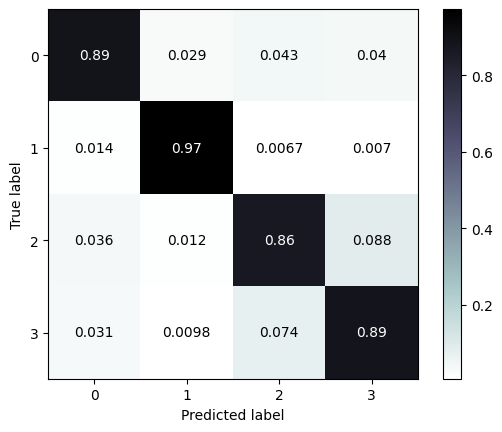

In [7]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, normalize='true', cmap='bone_r')

The success of model is moderate for classes 0,2 and 3. But we get pretty good predictions for news articles of class 1. Let us see what these labels mean.

In [8]:
for x in news.take(20):
    print(f'{x["label"]} => {x["title"]}')

3 => b'AMD Debuts Dual-Core Opteron Processor'
1 => b"Wood's Suspension Upheld (Reuters)"
2 => b'Bush reform may have blue states seeing red'
3 => b"'Halt science decline in schools'"
1 => b'Gerrard leaves practice'
0 => b'Sony Banking on MGM Deal to Boost Profits'
3 => b'Giant pandas in China reserve get Wi-Fi'
0 => b'Low turnout for Lithuania #39;s elections'
0 => b'Witness says CIA oversaw abuse at Abu Ghraib'
1 => b'Dan Olsen leads PGA qualifying school'
0 => b'Militants claim US official slowed UN hostage deal; official &lt;b&gt;...&lt;/b&gt;'
3 => b'Update: Four Infineon executives jailed for DRAM price-fixing'
3 => b'Yahoo Extends Microsoft Ad Deal'
0 => b'WHO Launches Polio Immunization In 23 African Countries'
2 => b'Diageo transfers shares to cut E1.1bn deficit'
1 => b'Henry scores two as Arsenal crushes Charlton 4-0'
0 => b'Implanted Lens Sharpens Blurred Vision'
3 => b'The Playboy Google Interview'
3 => b'Last Xmas order date for the Antipodes'
1 => b'Utah #39;s Urban Meyer

This sample shows us that articles on the subject of Sports are labelled as 2. So, our model is very accurate on sports articles.

#### A Different Vectorizer

It is possible that the success of the model is going to improve if we changed the vectorizer we have used to convert the text into vectors. Instead of [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) we can use [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [9]:
vectorizer = TfidfVectorizer(stop_words=list(stopwords.words('english')))
X = vectorizer.fit_transform(texts)
X_train, X_test, y_train, y_test = train_test_split(X,labels, test_size=0.2)
model = LR(max_iter=2500, solver='liblinear').fit(X_train,y_train)
y_predict = model.predict(X_test)

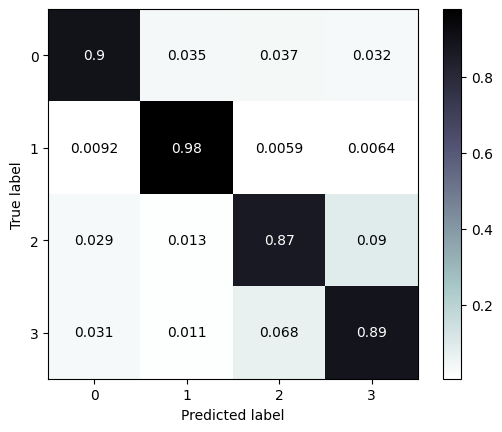

In [10]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, normalize='true', cmap='bone_r')

As you can see, the model's performance did not change. So, this models success does not depend on the vectorizer we have chosen.

#### A Different Model

Then how about we change the machine learning model we have used? Instead of using logistic regression, we may use another supervised classification algorithm. This time, I am going to use a [Support Vector Classifier](https://scikit-learn.org/stable/modules/svm.html) from [scikit-learn](https://scikit-learn.org/stable/index.html) called [`SVC`](https://scikit-learn.org/stable/modules/svm.html#classification).

In [11]:
vectorizer = TfidfVectorizer(stop_words=list(stopwords.words('english')))
X = vectorizer.fit_transform(texts)
X_train, X_test, y_train, y_test = train_test_split(X,labels, test_size=0.4)

/home/kaygun/local/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


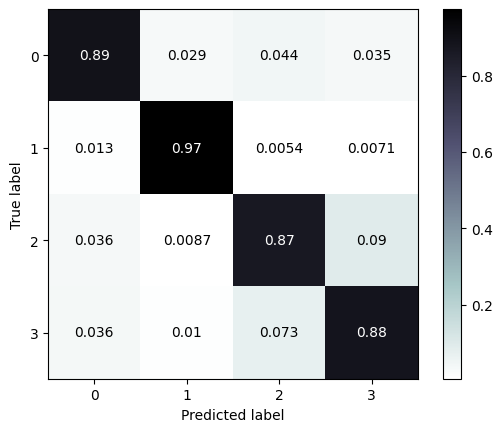

In [12]:
model = LinearSVC(max_iter=1000).fit(X_train,y_train)
y_predict = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, normalize='true', cmap='bone_r')

/home/kaygun/local/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


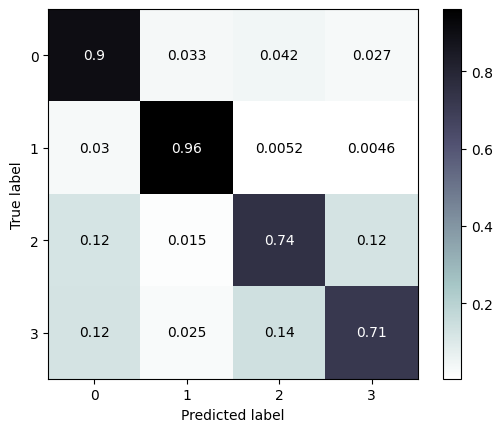

In [13]:
model = SVC(max_iter=1000).fit(X_train,y_train)
y_predict = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, normalize='true', cmap='bone_r')

#### Yet Another Model



In [16]:
model = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
y_predict = model.predict(X_test)

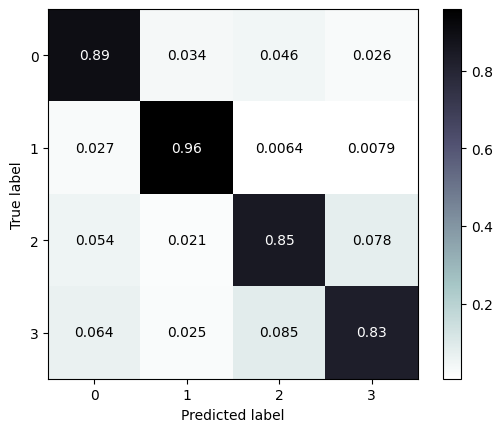

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, normalize='true', cmap='bone_r')

## Second Example: Image Classification

In earlier lectures, I have used [Olivetti Faces dataset](https://scikit-learn.org/0.19/datasets/olivetti_faces.html) to do a classification example. Today I am going to use [EUROSAT dataset](https://www.tensorflow.org/datasets/catalog/eurosat).

> EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral bands and consisting of 10 classes with 27000 labeled and geo-referenced samples. Two datasets are offered: - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image. - all: Contains all 13 bands in the original value range (float32).



In [18]:
eurosat = tfds.load('eurosat/all', split='train', data_dir='/home/kaygun/local/data/tensorflow_datasets/')

In [19]:
list(eurosat.take(5))

[{'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'River_15.tif'>,
  'label': <tf.Tensor: shape=(), dtype=int64, numpy=8>,
  'sentinel2': <tf.Tensor: shape=(64, 64, 13), dtype=float32, numpy=
  array([[[1138.,  909.,  832., ...,  129.,   77.,  354.],
          [1138.,  909.,  832., ...,  129.,   77.,  354.],
          [1138.,  916.,  826., ...,  127.,   75.,  351.],
          ...,
          [1172.,  864.,  845., ..., 1939.,  952., 3965.],
          [1177.,  865.,  892., ..., 1943.,  987., 3889.],
          [1181.,  828.,  844., ..., 1927.,  986., 3874.]],
  
         [[1138.,  909.,  832., ...,  129.,   77.,  354.],
          [1138.,  909.,  832., ...,  129.,   77.,  354.],
          [1138.,  916.,  826., ...,  127.,   75.,  351.],
          ...,
          [1172.,  864.,  845., ..., 1939.,  952., 3965.],
          [1177.,  865.,  892., ..., 1943.,  987., 3889.],
          [1181.,  828.,  844., ..., 1927.,  986., 3874.]],
  
         [[1138.,  916.,  824., ...,  132.,   79.,  349

In [20]:
data = []
labels = []
for x in eurosat.take(1000):
    tmp = x['sentinel2'].numpy()
    tmp.resize(64*64*13)
    data.append(tmp)
    labels.append(x['label'].numpy())

In [21]:
scaler = MinMaxScaler()
X = scaler.fit_transform(data)

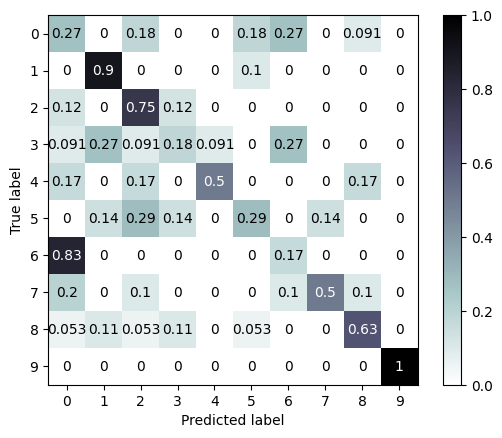

In [22]:
data_train, data_test, labels_train, labels_test = train_test_split(X,labels,test_size=0.1)
model = LR(max_iter=1500, solver='liblinear').fit(data_train, labels_train)
labels_predict = model.predict(data_test)
ConfusionMatrixDisplay.from_predictions(labels_test, labels_predict, normalize='true', cmap='bone_r')

### A Different Model



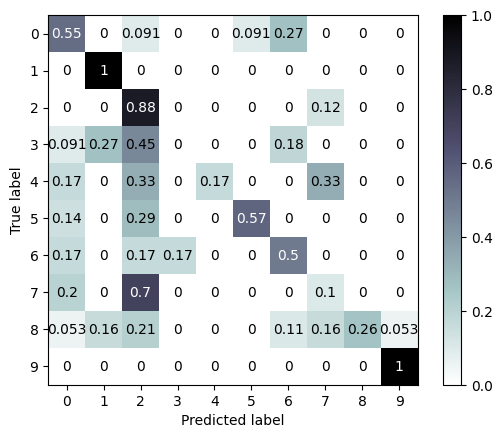

In [25]:
model = KNeighborsClassifier(n_neighbors=3).fit(data_train, labels_train)
labels_predict = model.predict(data_test)
ConfusionMatrixDisplay.from_predictions(labels_test, labels_predict, normalize='true', cmap='bone_r')

In [90]:
for x in eurosat.take(40):
    print(x['label'].numpy(), x['filename'].numpy())

8 b'River_15.tif'
4 b'Industrial_631.tif'
5 b'Pasture_1854.tif'
5 b'Pasture_497.tif'
3 b'Highway_1399.tif'
0 b'AnnualCrop_2921.tif'
4 b'Industrial_1094.tif'
0 b'AnnualCrop_926.tif'
0 b'AnnualCrop_2945.tif'
6 b'PermanentCrop_916.tif'
9 b'SeaLake_2033.tif'
3 b'Highway_1758.tif'
2 b'HerbaceousVegetation_1507.tif'
0 b'AnnualCrop_2966.tif'
9 b'SeaLake_1151.tif'
1 b'Forest_1938.tif'
2 b'HerbaceousVegetation_2664.tif'
2 b'HerbaceousVegetation_1531.tif'
2 b'HerbaceousVegetation_2042.tif'
4 b'Industrial_668.tif'
8 b'River_981.tif'
0 b'AnnualCrop_1517.tif'
4 b'Industrial_896.tif'
9 b'SeaLake_1133.tif'
7 b'Residential_2102.tif'
7 b'Residential_2605.tif'
4 b'Industrial_2075.tif'
6 b'PermanentCrop_770.tif'
6 b'PermanentCrop_1468.tif'
8 b'River_206.tif'
3 b'Highway_1709.tif'
4 b'Industrial_1023.tif'
2 b'HerbaceousVegetation_2629.tif'
7 b'Residential_826.tif'
0 b'AnnualCrop_1593.tif'
6 b'PermanentCrop_594.tif'
2 b'HerbaceousVegetation_1109.tif'
9 b'SeaLake_1257.tif'
3 b'Highway_1974.tif'
8 b'River_93

## Frequency Hunting

### The datasets

For this example, I am going to use 4 separate datasets:

1. [Number of measles cases in New York since 1928](https://ms.mcmaster.ca/~bolker/measdata/numeas.dat)
2. [Number of measles cases in Baltimore since 1928](https://ms.mcmaster.ca/~bolker/measdata/baltmeas.dat)
3. [Number of dengue fever cases in Puerto Rico](https://dengueforecasting.noaa.gov/Training/San_Juan_Training_Data.csv)
4. [Number of COVID deaths reported by WHO](https://covid19.who.int/WHO-COVID-19-global-data.csv)

First two sets come from [Infectious disease data](https://ms.mcmaster.ca/~bolker/measdata.html) by Ben Bolker. The data have been manually entered from published records by various people. The third dataset is provided by NOAA and is used to forecast dengue fever epidemics. The last one is provided by World Health Organization (WHO).

#### NY Measles Dataset

In [26]:
ny = pd.read_csv('https://ms.mcmaster.ca/~bolker/measdata/nycmeas.dat',sep=' ',header=None, dtype={0: 'string', 1: 'int'})
ny.columns = ['year', 'cases']
ny.index = ny['year']
del ny['year']
ny

,cases
year,
1928.000,609
1928.083,1516
1928.167,4952
1928.250,7466
1928.333,11155
...,...
1963.582,362
1963.665,168
1963.749,221


<Axes: xlabel='year'>

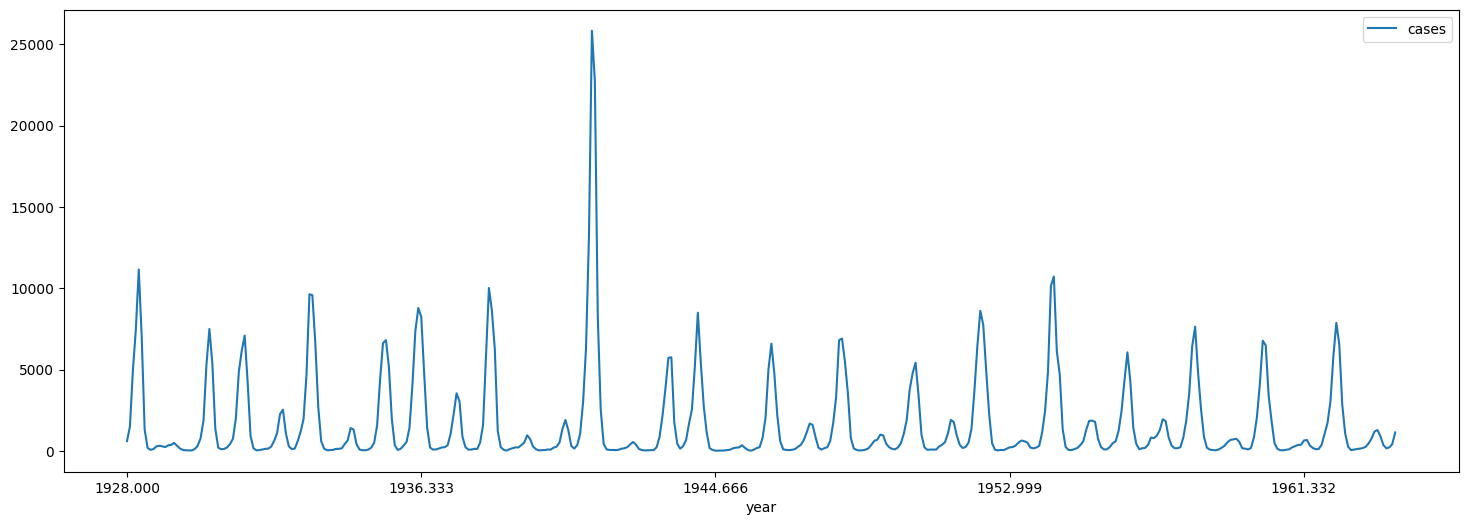

In [27]:
ny.plot(figsize=(18,6))

In [28]:
def get_freqs(data,N):
    freqs = np.abs(rfft(np.log(1+data)))[1:]
    dominant = [x[0]+1 for x in sorted(enumerate(freqs), key=lambda x: -x[1])][:N]
    plt.figure(figsize=(18,6))
    plt.plot(freqs)
    return dominant

[36, 14, 17, 18, 13, 72]

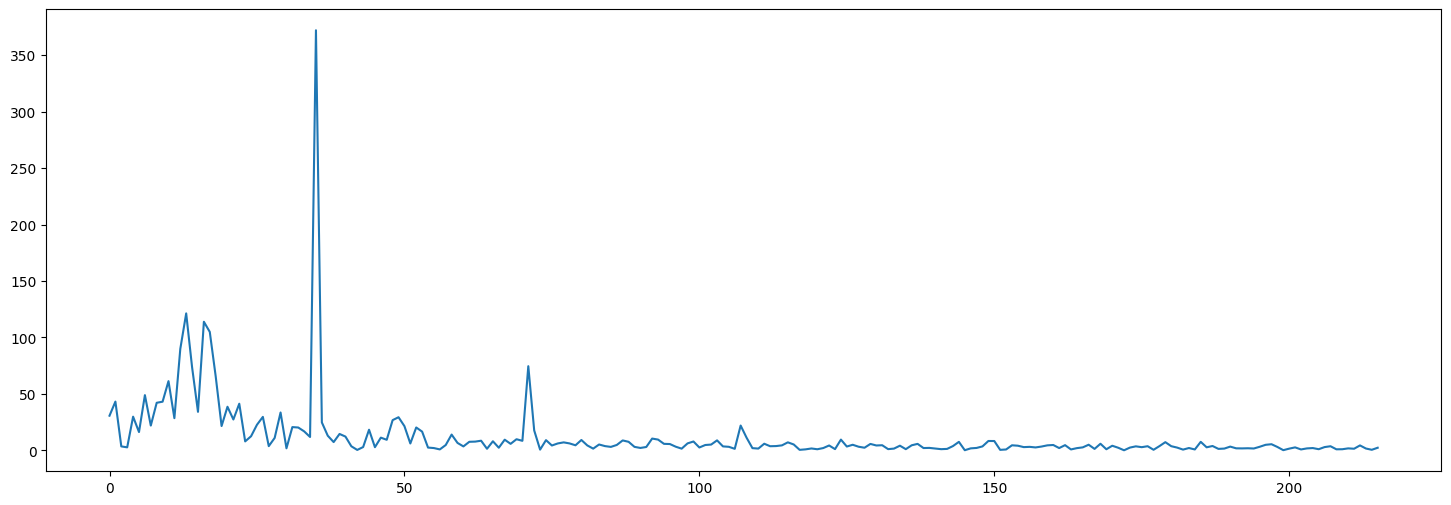

In [29]:
get_freqs(ny['cases'],6)

In [32]:
def get_spectrogram(data,fs,no,nfft,unit):
    f,t,Sxx = signal.spectrogram(data,fs=fs,noverlap=no,nfft=nfft,nperseg=fs)
    plt.figure(figsize=(12,4))
    plt.pcolormesh(t,f,Sxx,shading='gouraud')
    plt.ylabel('Frequency')
    plt.xlabel(f'Time [{unit}]')

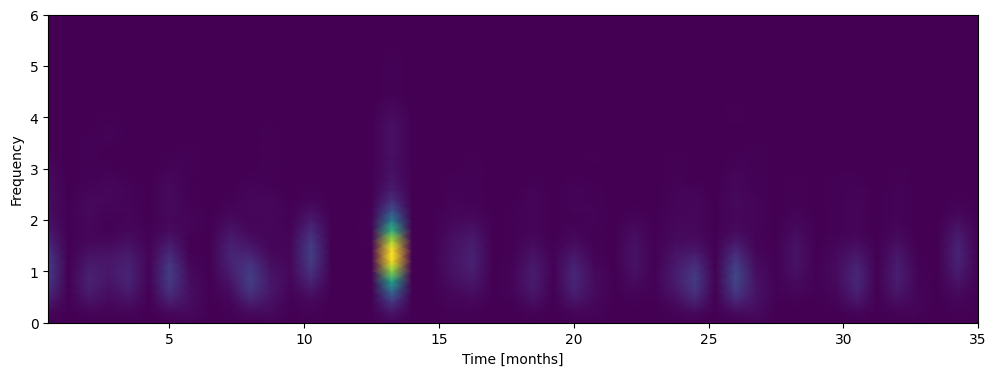

In [36]:
get_spectrogram(ny['cases'],12,3,60,'months')

In [40]:
def get_cwt(data,wavelet,fs):
    spec = signal.cwt(data, wavelet, fs)
    plt.figure(figsize=(12,4))
    plt.imshow(np.flipud(np.abs(spec)))

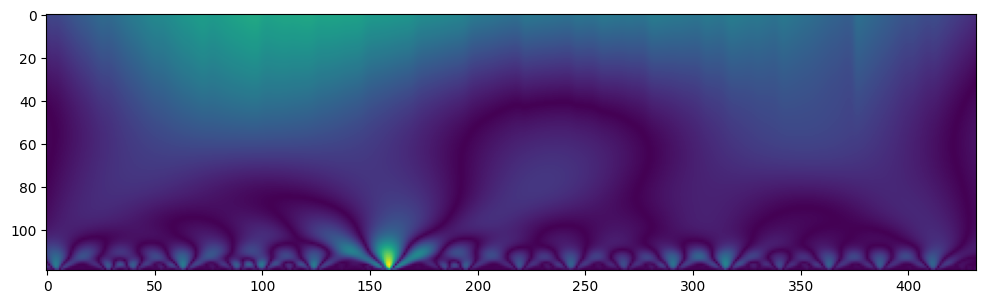

In [41]:
get_cwt(ny['cases'], signal.ricker, np.arange(1,120))

In [50]:
def spectrum_analysis(data,fs,N):
    f,spec = signal.welch(data,fs,'flattop',N,scaling='spectrum')
    plt.figure(figsize=(18,5))
    plt.semilogy(f,np.sqrt(spec))

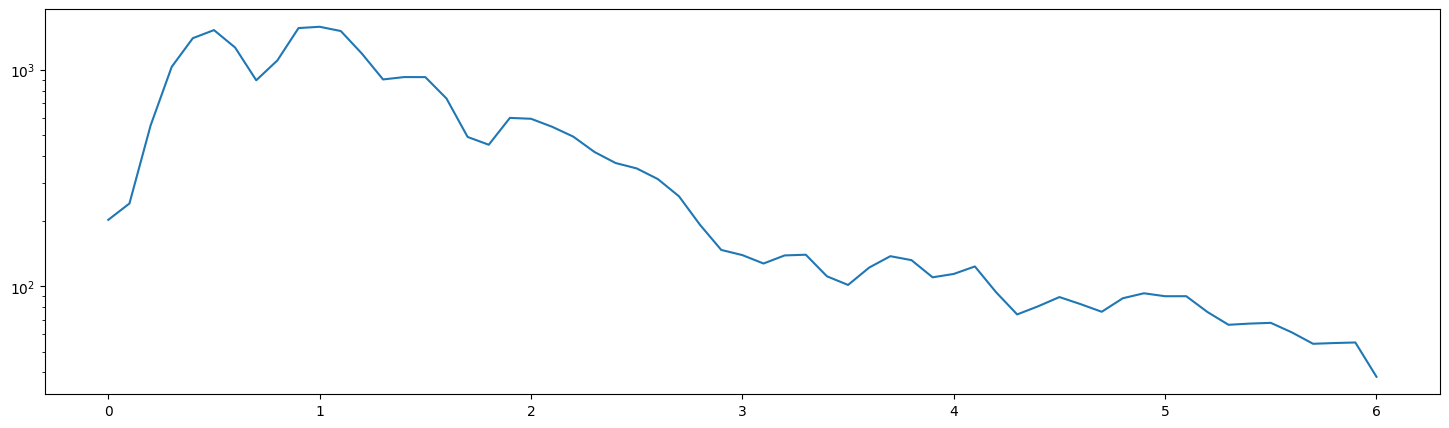

In [51]:
spectrum_analysis(ny['cases'],12,120)

#### Baltimore Measles Dataset

In [43]:
balt = pd.read_csv('https://ms.mcmaster.ca/~bolker/measdata/baltmeas.dat',sep=' ',header=None, dtype={0: 'string', 1: 'int'})
balt.columns = ['year', 'cases']
balt.index = balt['year']
del balt['year']
balt

,cases
year,
1928.000,1158
1928.083,2371
1928.167,3752
1928.250,2746
1928.333,1792
...,...
1963.583,90
1963.667,34
1963.750,61


<Axes: xlabel='year'>

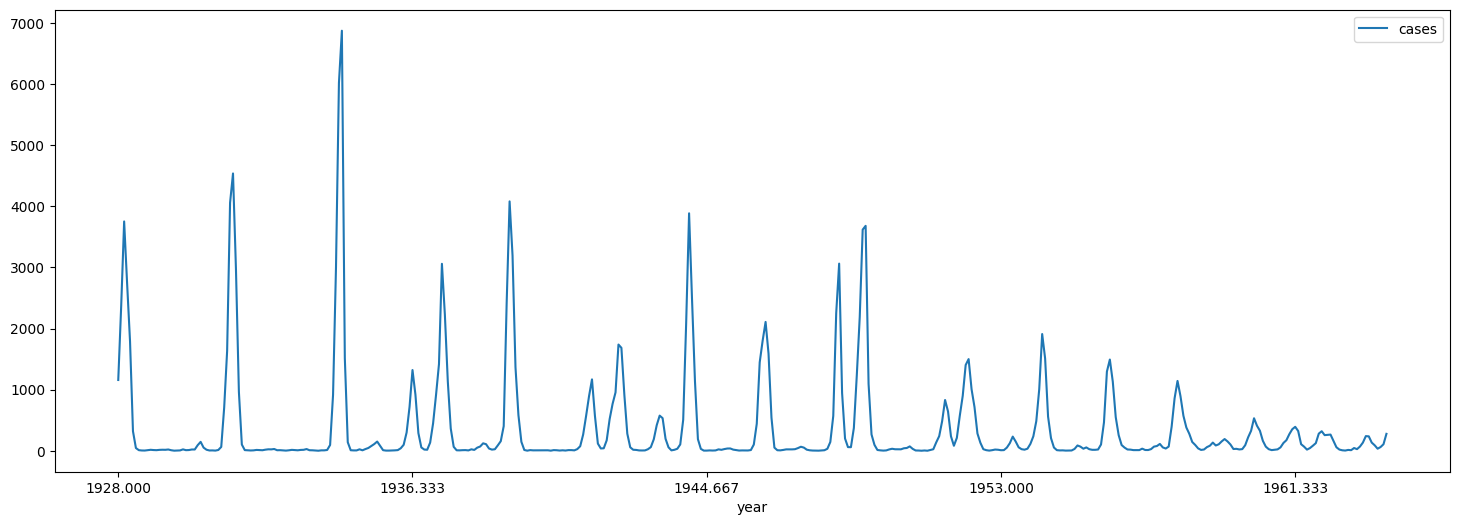

In [44]:
balt.plot(figsize=(18,6))

[36, 14, 15, 12, 19, 10]

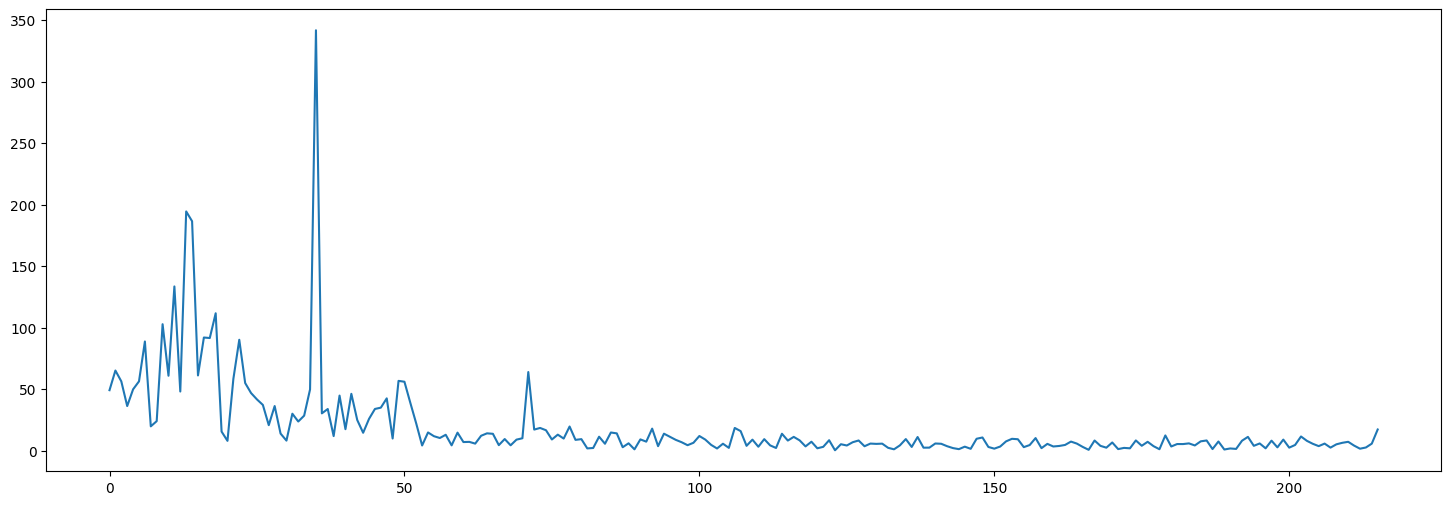

In [45]:
get_freqs(balt['cases'],6)

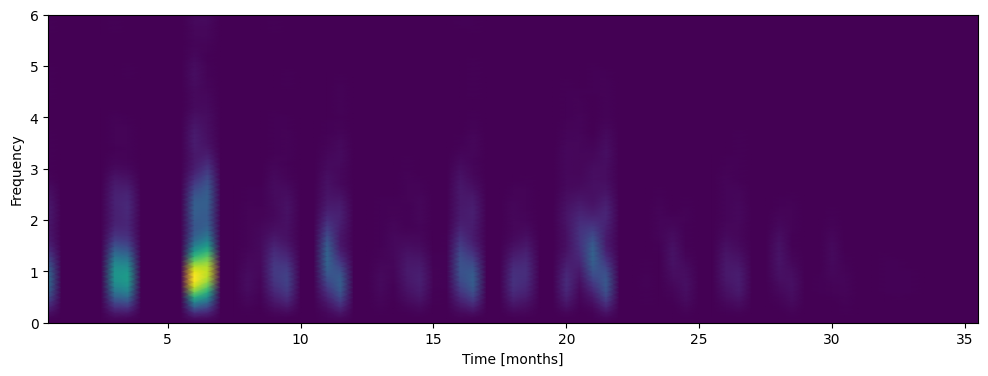

In [46]:
get_spectrogram(balt['cases'],12,6,120,'months')

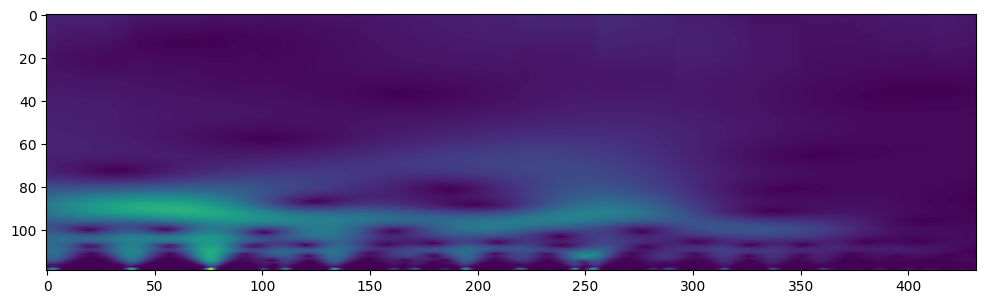

In [47]:
get_cwt(balt['cases'], signal.morlet2, np.arange(1,120))

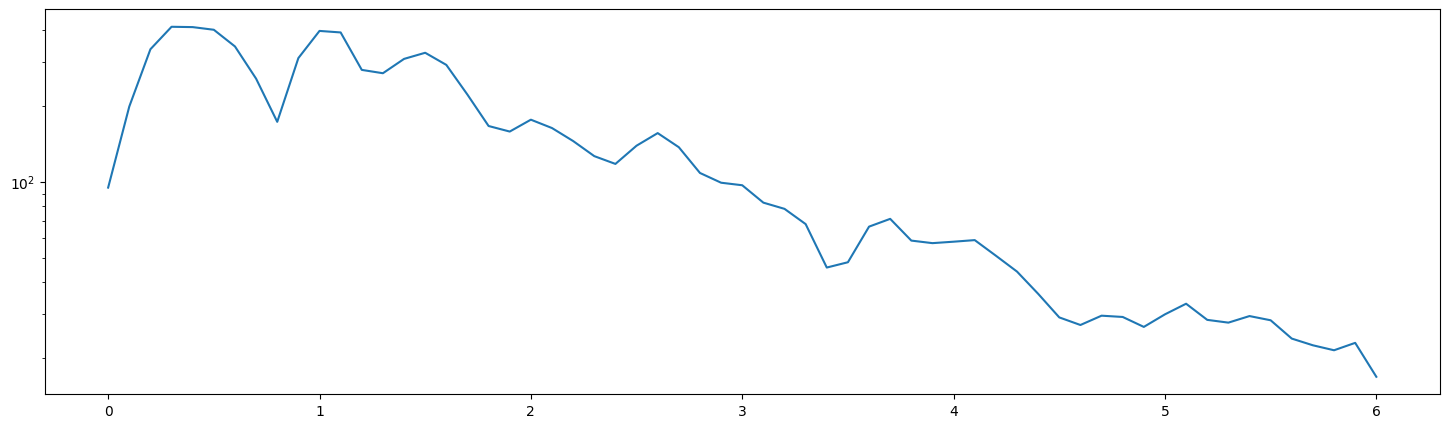

In [52]:
spectrum_analysis(balt['cases'],12,120)

#### Number of Dengue Fever Cases in Puerto Rico

In [54]:
dengue = pd.read_csv('https://dengueforecasting.noaa.gov/Training/San_Juan_Training_Data.csv')
dengue

,season,season_week,week_start_date,denv1_cases,denv2_cases,denv3_cases,denv4_cases,other_positive_cases,additional_cases,total_cases
0,1990/1991,1,1990-04-30,0,0,0,0,4,0,4
1,1990/1991,2,1990-05-07,0,0,0,0,5,0,5
2,1990/1991,3,1990-05-14,0,0,0,0,4,0,4
3,1990/1991,4,1990-05-21,0,0,0,0,3,0,3
4,1990/1991,5,1990-05-28,0,0,0,0,6,0,6
...,...,...,...,...,...,...,...,...,...,...
983,2008/2009,48,2009-03-26,11,0,0,0,13,0,24
984,2008/2009,49,2009-04-02,4,0,0,1,4,0,9
985,2008/2009,50,2009-04-09,13,0,0,1,7,0,21
986,2008/2009,51,2009-04-16,7,0,0,0,3,0,10


[19, 1, 6, 5, 10, 3]

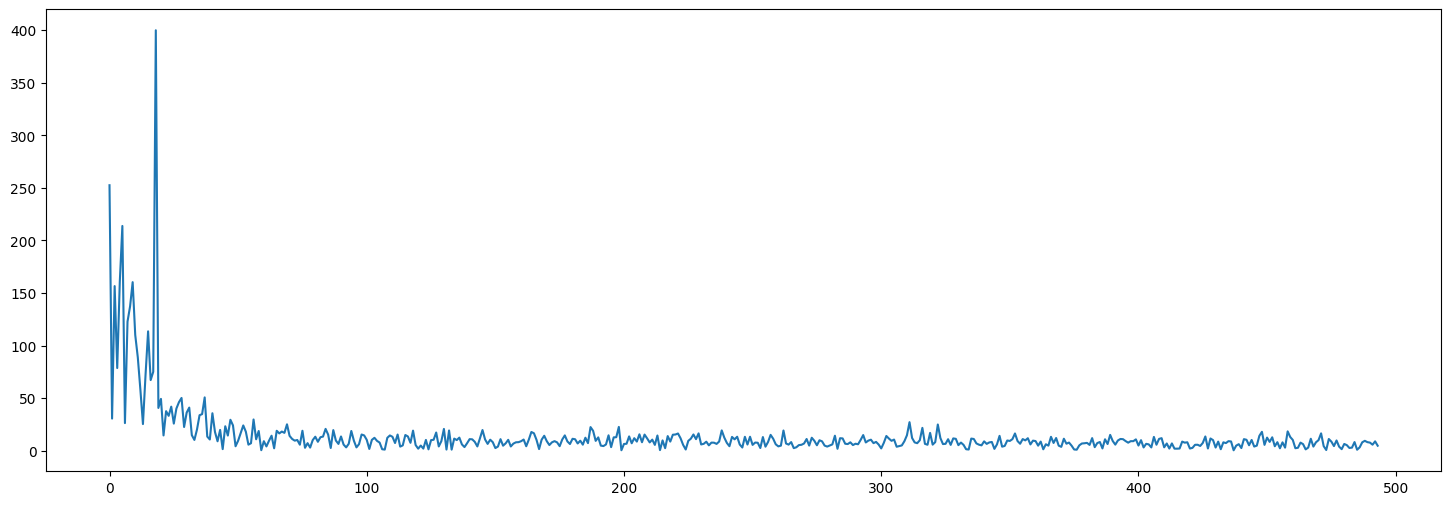

In [55]:
get_freqs(dengue['total_cases'],6)

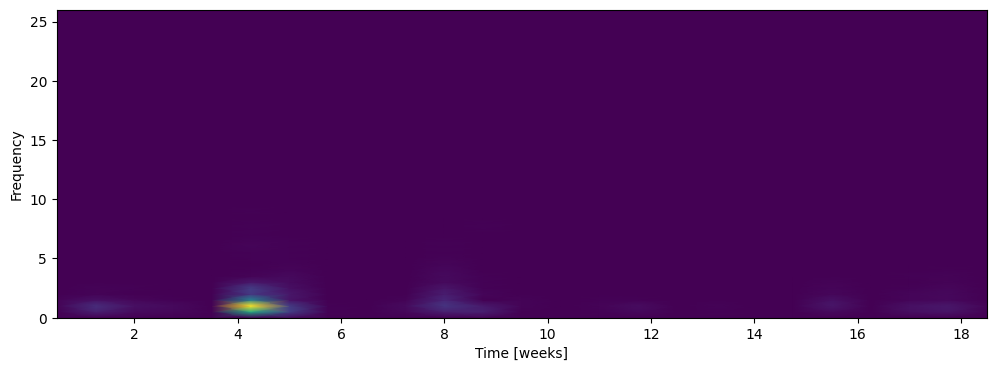

In [56]:
get_spectrogram(dengue['total_cases'],52,13,104,'weeks')

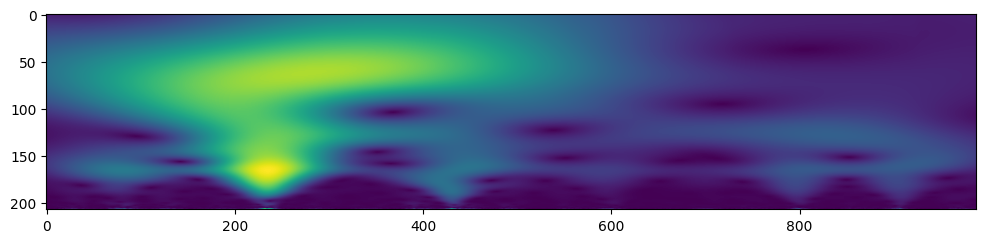

In [57]:
get_cwt(dengue['total_cases'], signal.morlet2, np.arange(1,208))

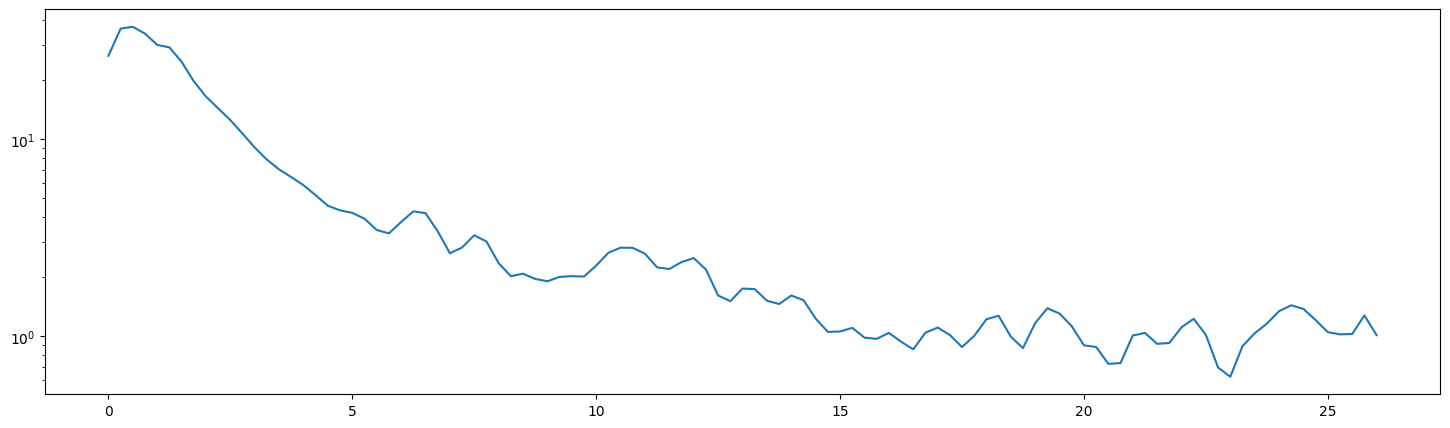

In [58]:
spectrum_analysis(dengue['total_cases'],52,208)

#### Global COVID Dataset

In [59]:
covid = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
covid

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0
...,...,...,...,...,...,...,...,...
336535,2023-11-18,ZW,Zimbabwe,AFRO,0,265890,0,5725
336536,2023-11-19,ZW,Zimbabwe,AFRO,0,265890,0,5725
336537,2023-11-20,ZW,Zimbabwe,AFRO,0,265890,0,5725
336538,2023-11-21,ZW,Zimbabwe,AFRO,0,265890,0,5725


In [60]:
covid_cases = duckdb.sql("""
    pivot covid on Country_code 
        using sum(New_cases) as cases, sum(New_deaths) as deaths
        group by Date_reported
        order by Date_reported
""").to_df()
covid_cases

,Date_reported,_cases,_deaths,AD_cases,AD_deaths,AE_cases,AE_deaths,AF_cases,AF_deaths,AG_cases,...,YE_cases,YE_deaths,YT_cases,YT_deaths,ZA_cases,ZA_deaths,ZM_cases,ZM_deaths,ZW_cases,ZW_deaths
0,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,2023-11-18,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1416,2023-11-19,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1417,2023-11-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1418,2023-11-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='Date_reported'>

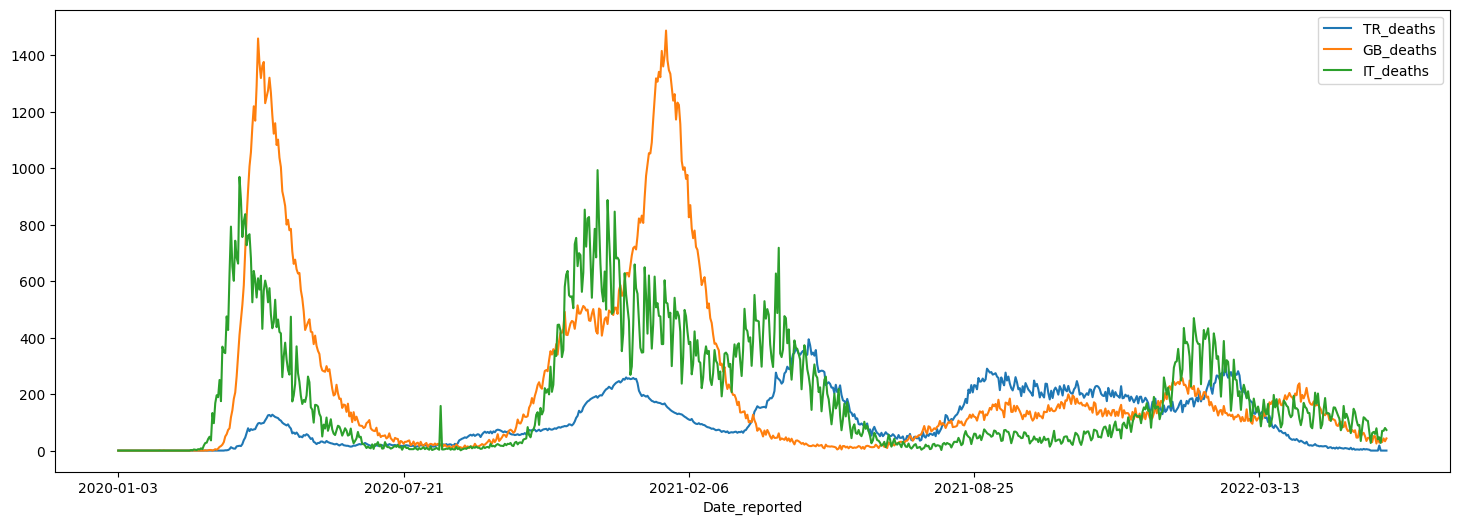

In [61]:
tmp = covid_cases[['TR_deaths','GB_deaths','IT_deaths']]
tmp.index = covid_cases['Date_reported']
tmp[:890].plot(figsize=(18,6))

[1, 2, 3, 5, 4, 7]

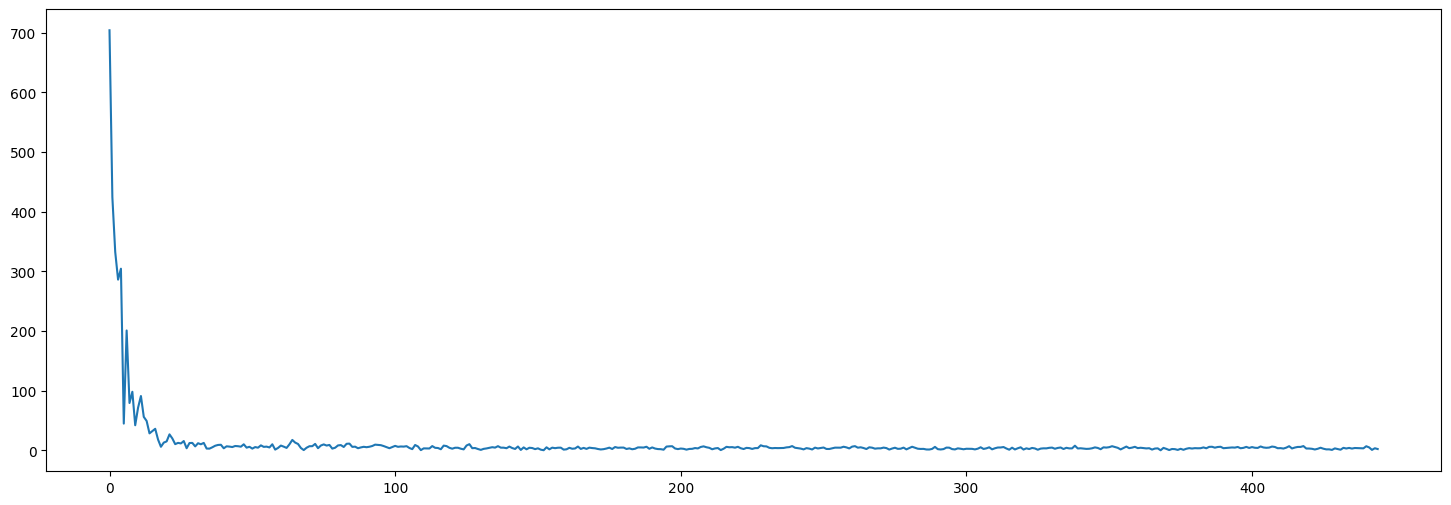

In [62]:
get_freqs(covid_cases['TR_deaths'].iloc[:890],6)

[6, 1, 5, 2, 3, 7]

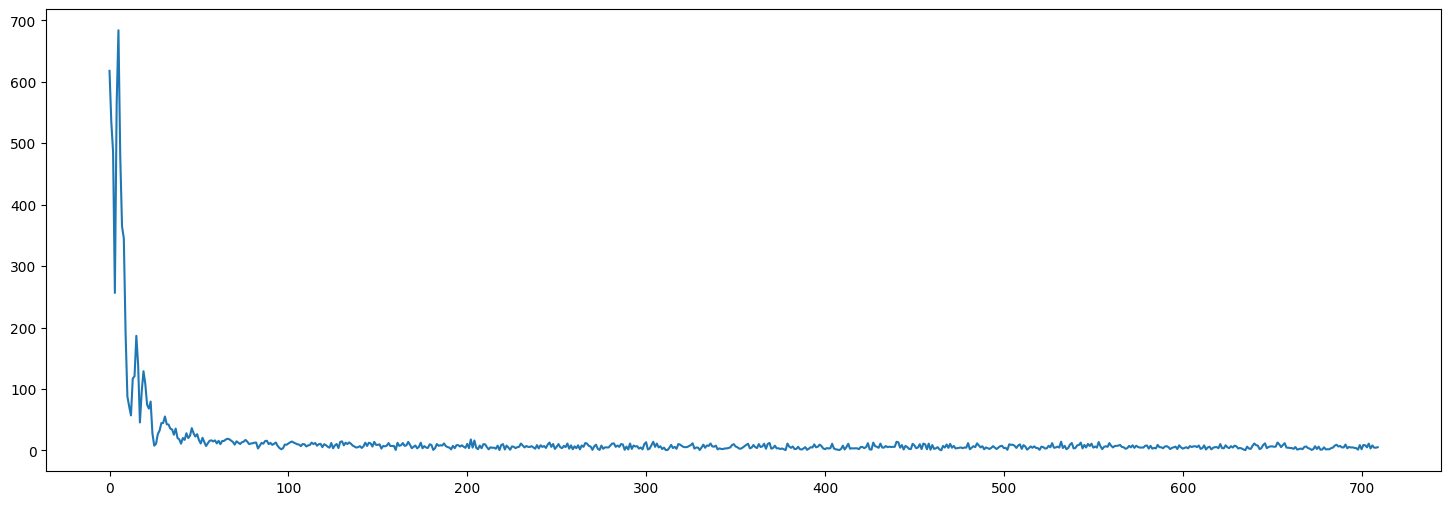

In [63]:
get_freqs(covid_cases['GB_deaths'],6)

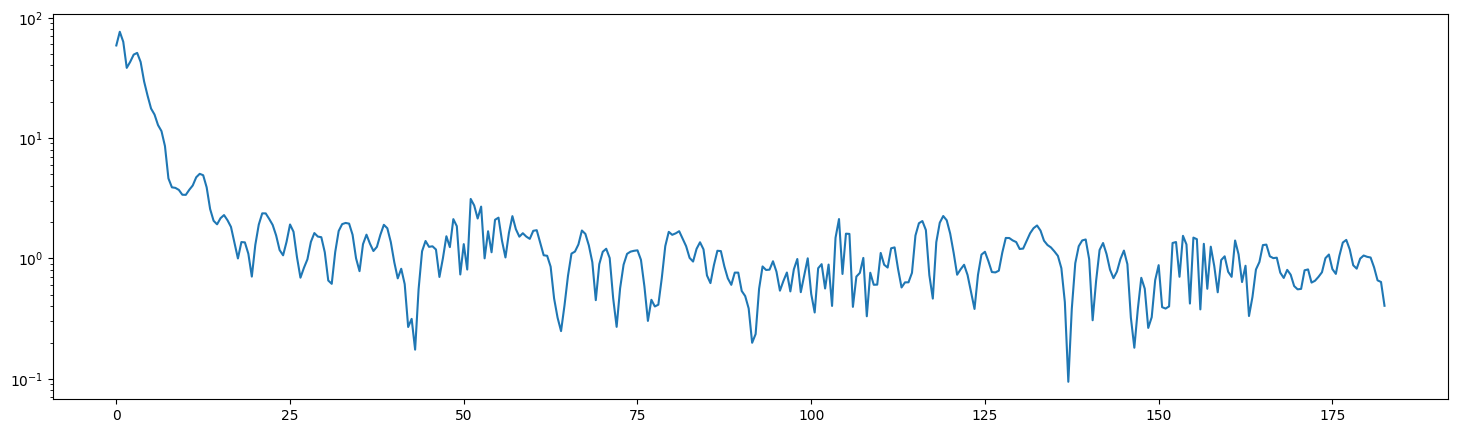

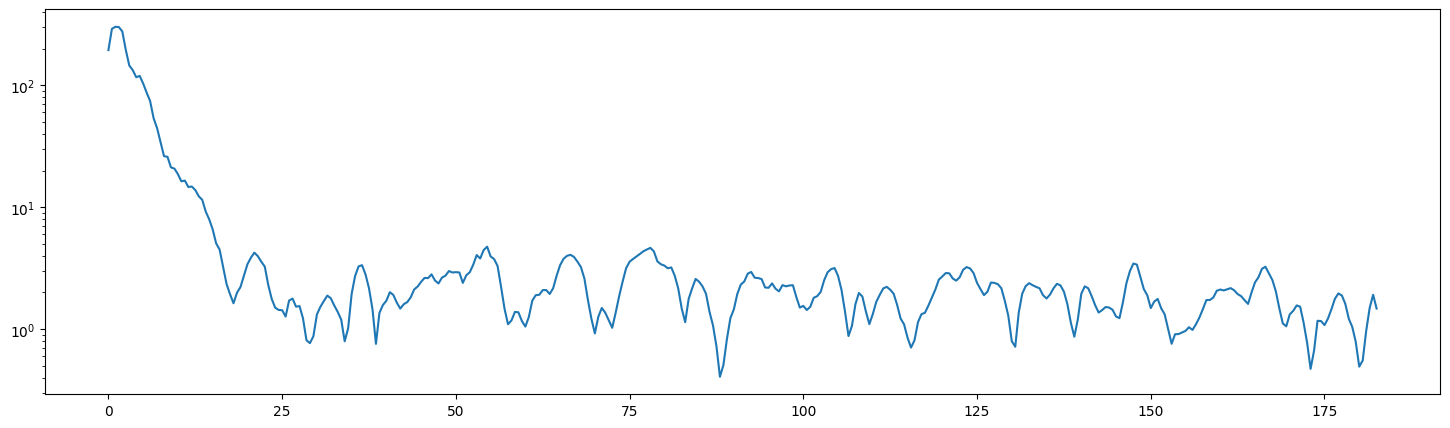

In [67]:
spectrum_analysis(covid_cases['TR_deaths'],365,730)
spectrum_analysis(covid_cases['GB_deaths'],365,730)

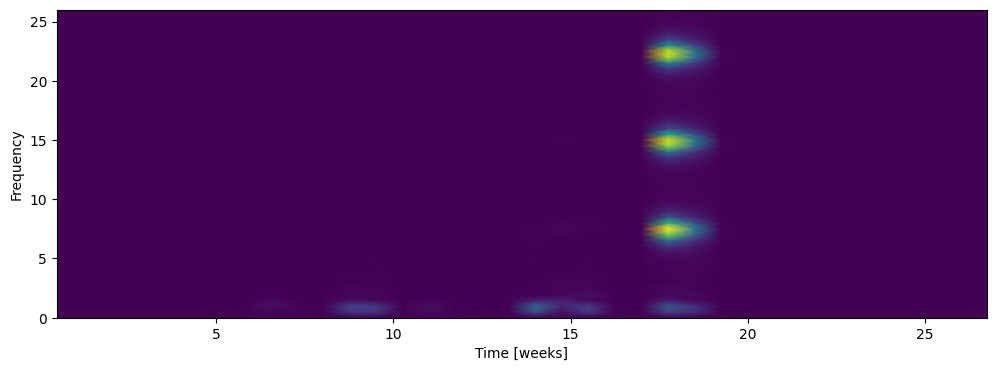

In [68]:
get_spectrogram(covid_cases['TR_cases'],52,13,104,'weeks')

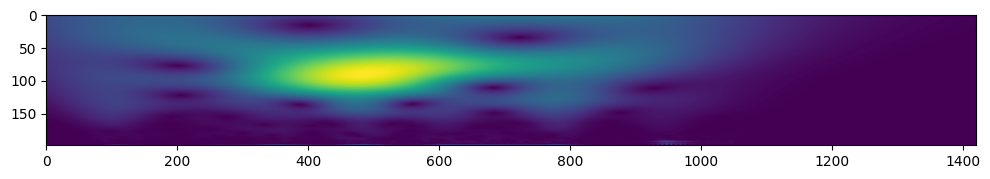

In [69]:
get_cwt(covid_cases['TR_deaths'], signal.morlet2, np.arange(1,200))

### IBB Hourly Transportation Data

In [70]:
ibb = pd.read_parquet('../shared/data/ist_hourly_transportation_2023_10.parquet')
ibb

,transition_date,transition_hour,transport_type_id,road_type,line,transfer_type,number_of_passage,number_of_passenger
0,2023-10-01,0,2,RAYLI,LEVENT-HISAR USTU,Aktarma,3,3
1,2023-10-01,0,3,DENİZ,BESIKTAS-USKUDAR,Normal,10,7
2,2023-10-01,0,1,OTOYOL,KIRAC-AVCILAR METROBUS,Normal,2,2
3,2023-10-01,0,1,OTOYOL,HACI OSMAN METRO - KILYOS,Normal,1,1
4,2023-10-01,0,1,OTOYOL,GUNESLI - BEYAZIT,Normal,13,13
...,...,...,...,...,...,...,...,...
4178707,2023-10-31,23,1,OTOYOL,SARIYER-BESIKTAS,Normal,2,2
4178708,2023-10-31,23,1,OTOYOL,UGURMUMCU-ESENKENT METRO,Aktarma,1,1
4178709,2023-10-31,23,1,OTOYOL,SAHINTEPE-OLIMPIYATKOY METRO,Normal,4,4
4178710,2023-10-31,23,1,OTOYOL,ATAKENT-AKSARAY,Normal,7,7


In [71]:
res = duckdb.sql("""
    pivot ibb on road_type
          using sum(number_of_passenger)
          group by transition_date, transition_hour
          order by transition_date, transition_hour
""").to_df()
res.fillna(0,inplace=True)
res

,transition_date,transition_hour,DENİZ,OTOYOL,RAYLI
0,2023-10-01,0,1321.0,17251.0,19720.0
1,2023-10-01,1,270.0,7169.0,8762.0
2,2023-10-01,2,70.0,4068.0,3561.0
3,2023-10-01,3,26.0,2500.0,1904.0
4,2023-10-01,4,43.0,2304.0,1487.0
...,...,...,...,...,...
716,2023-10-31,19,10594.0,272119.0,229996.0
717,2023-10-31,20,5873.0,163469.0,124971.0
718,2023-10-31,21,4205.0,113756.0,91031.0
719,2023-10-31,22,3127.0,90212.0,77373.0


<Axes: >

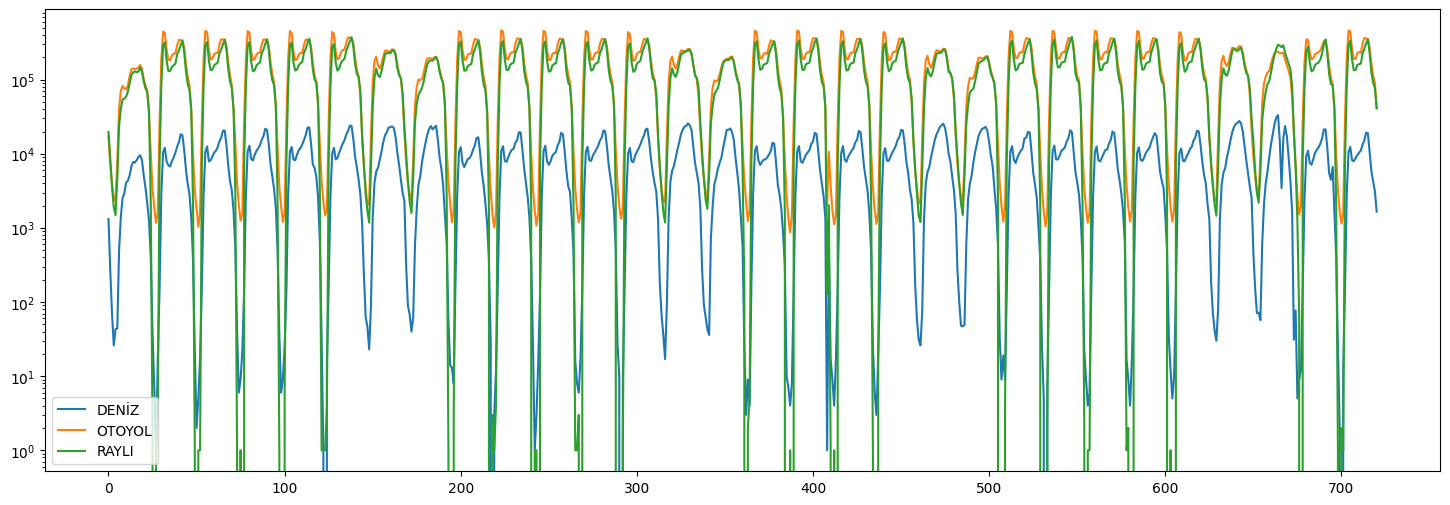

In [72]:
res[['DENİZ','OTOYOL','RAYLI']].plot(figsize=(18,6),logy=True)

[30, 60, 90, 120, 150, 180, 69]

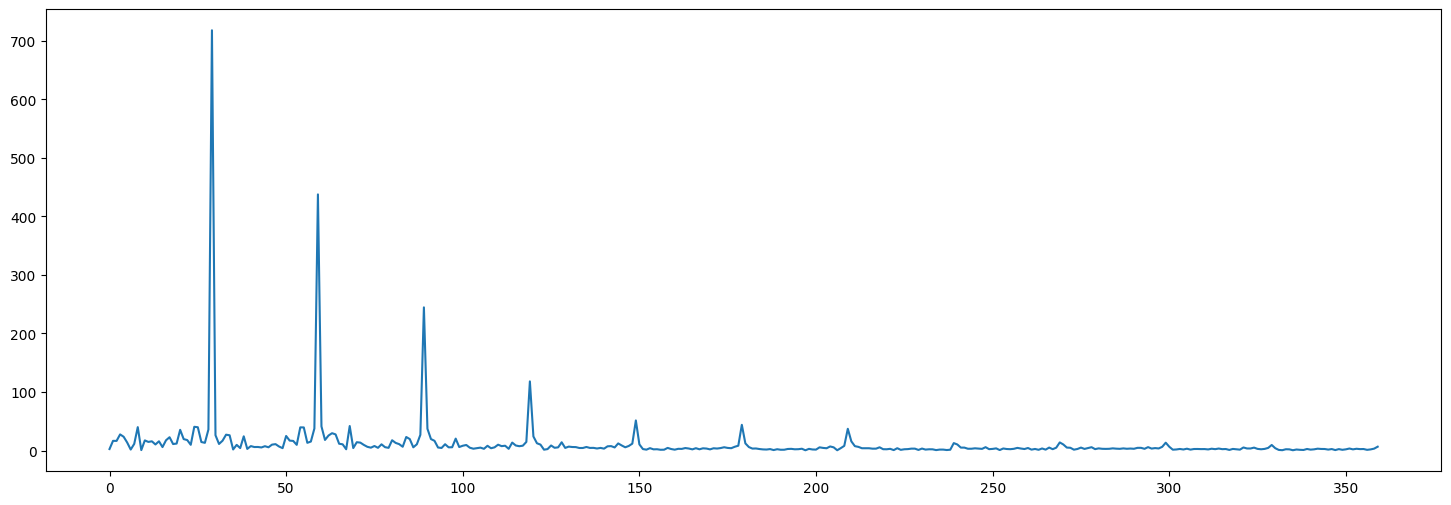

In [73]:
get_freqs(res['OTOYOL'],7)

[30, 60, 90, 120]

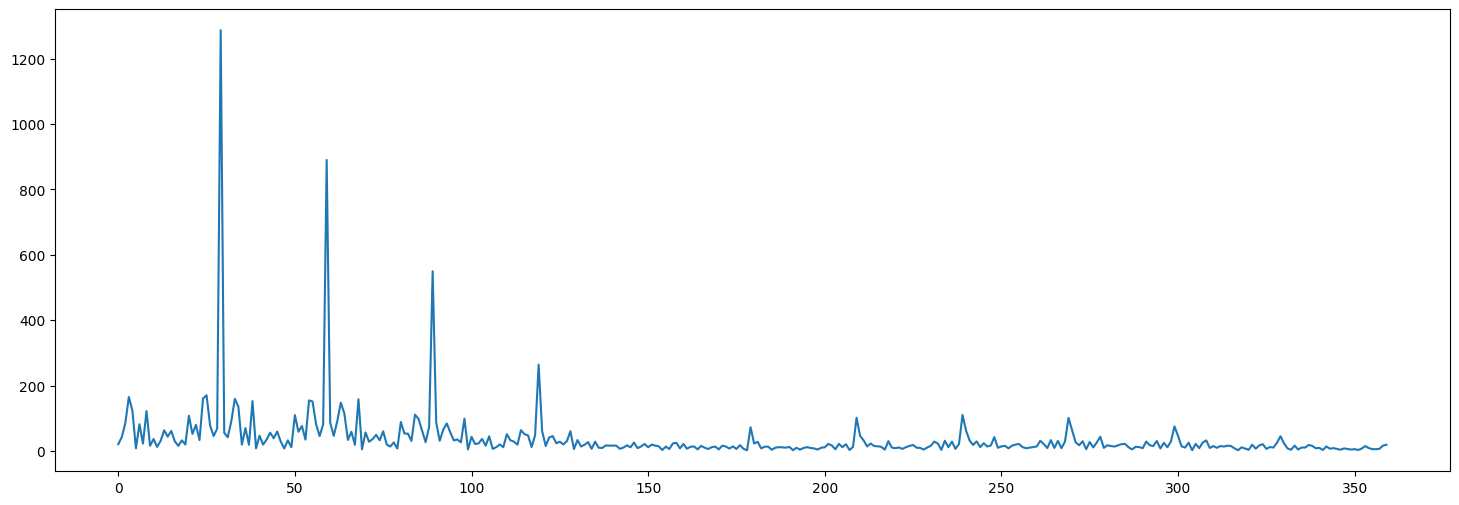

In [74]:
get_freqs(res['RAYLI'],4)

[30, 60, 90, 120]

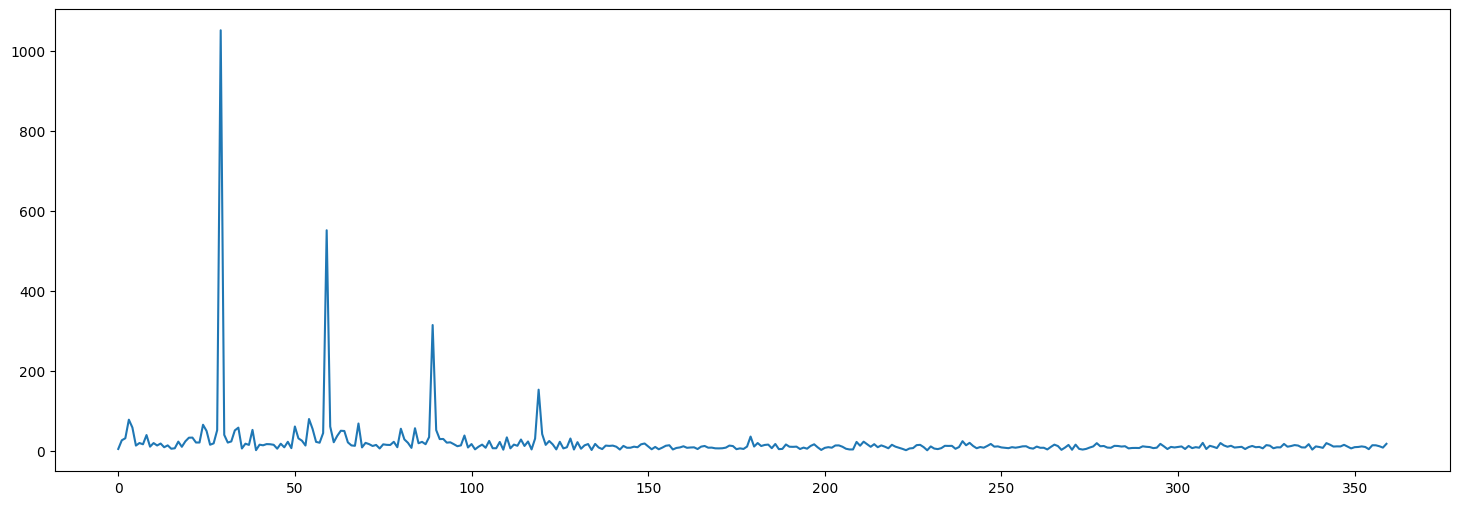

In [75]:
get_freqs(res['DENİZ'],4)

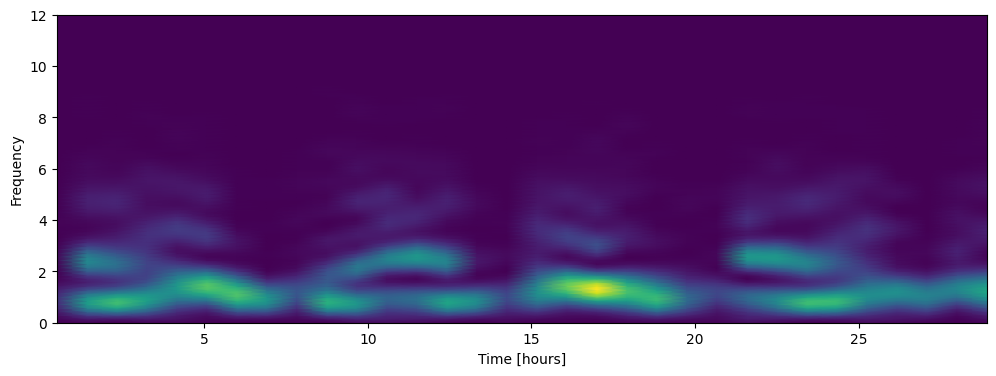

In [76]:
get_spectrogram(res['OTOYOL'],24,2,7*24,'hours')

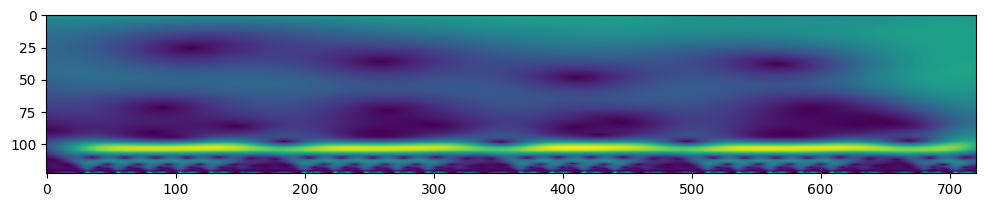

In [77]:
get_cwt(res['OTOYOL'], signal.morlet2, np.arange(1,124))

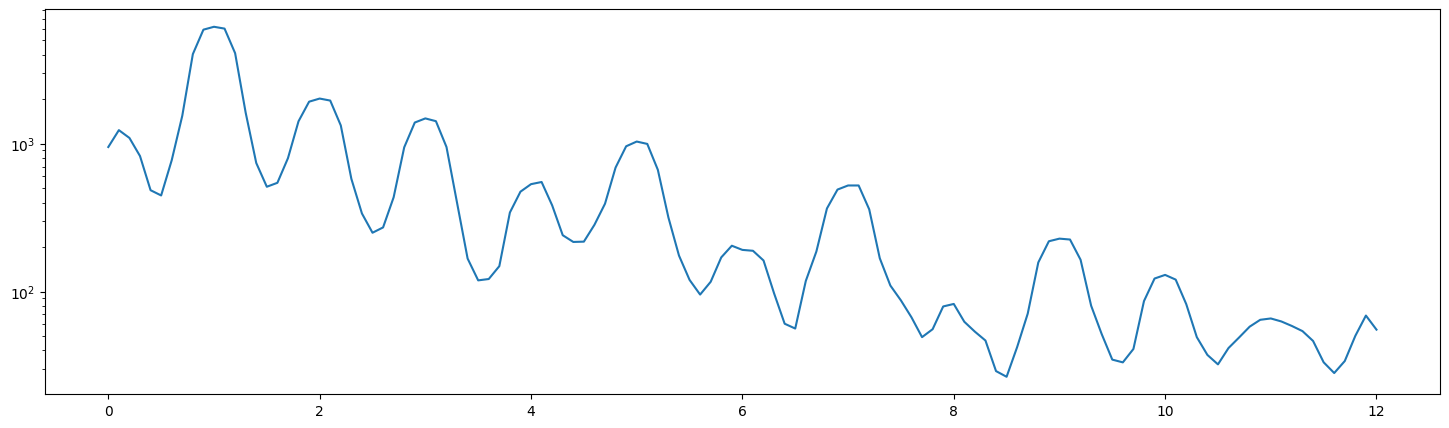

In [78]:
spectrum_analysis(res['DENİZ'],24,240)

# Time Series 

## Correlation and Coherence



In [79]:
res[['DENİZ','OTOYOL','RAYLI']].corr()

,DENİZ,OTOYOL,RAYLI
DENİZ,1.000000,0.786959,0.876433
OTOYOL,0.786959,1.000000,0.962624
RAYLI,0.876433,0.962624,1.000000


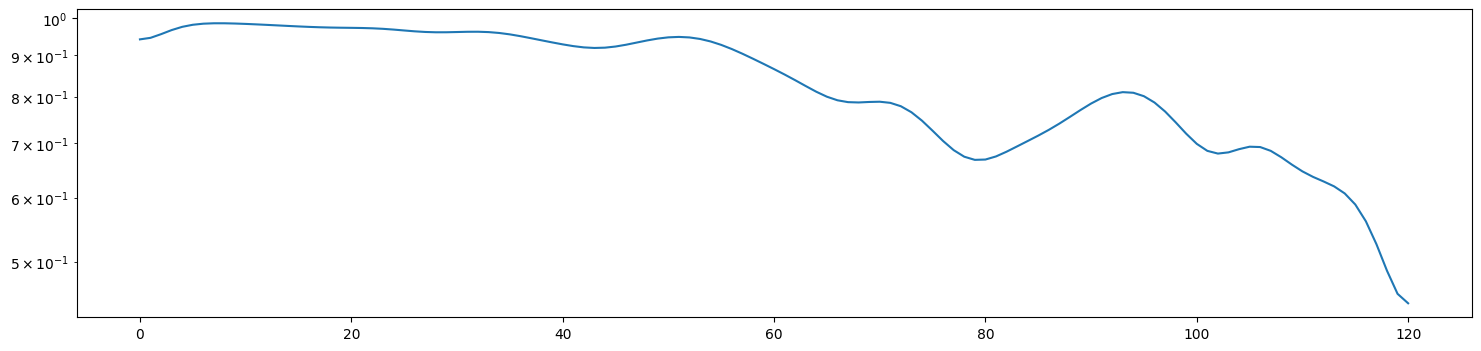

In [83]:
f,Cxy = signal.coherence(res['OTOYOL'],res['RAYLI'],fs=24,nfft=240,noverlap=6,nperseg=24)
plt.figure(figsize=(18,4))
plt.semilogy(Cxy)

In [84]:
ts = yf.download(['AAPL','NVDA','AMD'])
ts

[*********************100%%**********************]  3 of 3 completed


Adj Close                               Close              \
                  AAPL         AMD        NVDA        AAPL         AMD   
Date                                                                     
1980-03-17         NaN    3.145833         NaN         NaN    3.145833   
1980-03-18         NaN    3.031250         NaN         NaN    3.031250   
1980-03-19         NaN    3.041667         NaN         NaN    3.041667   
1980-03-20         NaN    3.010417         NaN         NaN    3.010417   
1980-03-21         NaN    2.916667         NaN         NaN    2.916667   
...                ...         ...         ...         ...         ...   
2023-11-17  189.690002  120.620003  492.980011  189.690002  120.620003   
2023-11-20  191.449997  121.529999  504.089996  191.449997  121.529999   
2023-11-21  190.639999  119.160004  499.440002  190.639999  119.160004   
2023-11-22  191.309998  122.510002  487.160004  191.309998  122.510002   
2023-11-24  189.970001  122.309998  477.760010  189.970001  122.309998   

                              High                                 Low  \
                  NVDA        AAPL         AMD        NVDA        AAPL   
Date                                                                     
1980-03-17         NaN         NaN    3.302083         NaN         NaN   
1980-03-18         NaN         NaN    3.125000         NaN         NaN   
1980-03-19         NaN         NaN    3.083333         NaN         NaN   
1980-03-20         NaN         NaN    3.062500         NaN         NaN   
1980-03-21         NaN         NaN    3.020833         NaN         NaN   
...                ...         ...         ...         ...         ...   
2023-11-17  492.980011  190.380005  121.489998  497.170013  188.570007   
2023-11-20  504.089996  191.910004  121.930000  505.480011  189.880005   
2023-11-21  499.440002  191.520004  120.650002  505.170013  189.740005   
2023-11-22  487.160004  192.929993  124.760002  503.350006  190.830002   
2023-11-24  477.760010  190.899994  123.250000  489.209991  189.250000   

                                          Open                          \
                   AMD        NVDA        AAPL         AMD        NVDA   
Date                                                                     
1980-03-17    3.125000         NaN         NaN    0.000000         NaN   
1980-03-18    2.937500         NaN         NaN    0.000000         NaN   
1980-03-19    3.020833         NaN         NaN    0.000000         NaN   
1980-03-20    3.010417         NaN         NaN    0.000000         NaN   
1980-03-21    2.906250         NaN         NaN    0.000000         NaN   
...                ...         ...         ...         ...         ...   
2023-11-17  118.820000  490.070007  190.250000  119.639999  495.239990   
2023-11-20  120.070000  491.809998  189.889999  120.699997  493.119995   
2023-11-21  117.940002  492.220001  191.410004  120.540001  501.260010   
2023-11-22  119.949997  476.899994  191.490005  120.000000  498.519989   
2023-11-24  121.540001  477.450012  190.869995  122.029999  484.700012   

                Volume                        
                  AAPL       AMD        NVDA  
Date                                          
1980-03-17         NaN    219600         NaN  
1980-03-18         NaN    727200         NaN  
1980-03-19         NaN    295200         NaN  
1980-03-20         NaN    159600         NaN  
1980-03-21         NaN    130800         NaN  
...                ...       ...         ...  
2023-11-17  50922700.0  38508900  32520500.0  
2023-11-20  46505100.0  43138700  41412000.0  
2023-11-21  38134500.0  41064800  56574700.0  
2023-11-22  39617700.0  56862200  89942000.0  
2023-11-24  24048300.0  19001000  29464500.0  

[11017 rows x 18 columns]

In [85]:
new = ts['Open'].dropna()
new.corr()

,AAPL,AMD,NVDA
AAPL,1.000000,0.900598,0.923862
AMD,0.900598,1.000000,0.891978
NVDA,0.923862,0.891978,1.000000


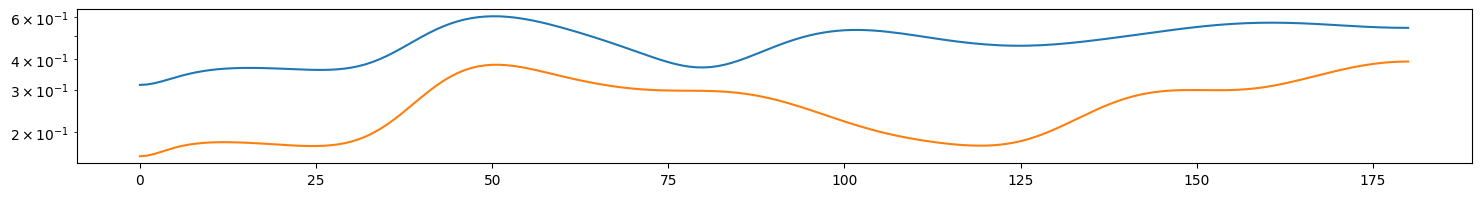

In [89]:
f,Cxy = signal.coherence(new['AMD'],new['NVDA'],fs=360,nperseg=20,noverlap=5,nfft=360)
plt.figure(figsize=(18,2))
plt.semilogy(Cxy)
f,Cxy = signal.coherence(new['AMD'],new['AAPL'],fs=360,nperseg=20,noverlap=5,nfft=360)
plt.semilogy(Cxy)

In [ ]:

f,Cxy = signal.coherence(new['AAPL'],new['NVDA'],fs=360,nperseg=20,noverlap=5,nfft=360)
plt.semilogy(Cxy)

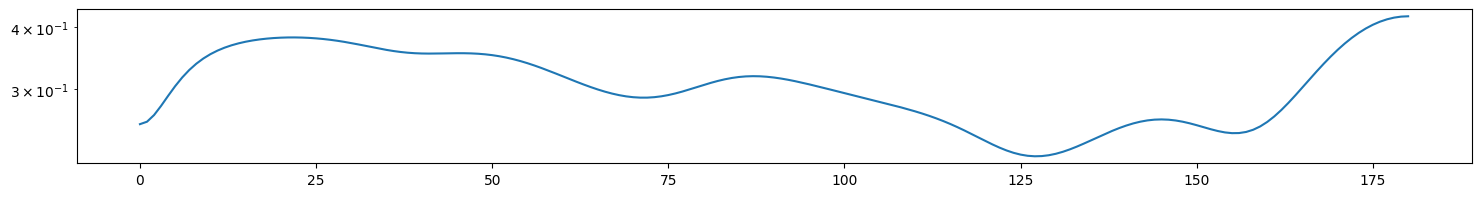